In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist
(X_train,y_train),(X_test,y_test) = mnist.load_data()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
#reshape and normalizing
X_train = X_train.reshape(X_train.shape[0],28*28).astype('float32')/255
X_test =  X_test.reshape(X_test.shape[0],28*28).astype('float32')/255

In [5]:
batch_size = 2048
X_train_batch = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1024).batch(batch_size)

In [6]:
lat_dim = 32 #Latent space dimension

In [7]:
#reparameterization trick

def reparameterize(mu,logvar):
    std  = tf.exp( 0.5 * logvar)
    eps = tf.random.normal(tf.shape(logvar))
    z = mu + eps*std
    return z

In [8]:
#encoder layers

i = Input(shape = (X_train.shape[1]),)
enc_1 = Dense(256,activation = 'relu')
enc_2 = Dense(128,activation = 'relu')
enc_3 = Dense(64,activation = 'relu')
    
enc_mu = Dense(lat_dim)
enc_logvar = Dense(lat_dim)
    
#Decoder layers
dec_1 = Dense(128,activation = 'relu')
dec_2 = Dense(256,activation = 'relu')
dec_3 = Dense(512,activation = 'relu')
dec_4 = Dense(X_train.shape[1],activation = 'sigmoid')


In [9]:
def forwardprop(x):
    #encoder
    
    l2 = enc_1(x)
    l3 = enc_2(l2)
    l4 = enc_3(l3)

    mu = enc_mu(l4)
    logvar = enc_logvar(l4)
    z = reparameterize(mu,logvar)

    #decoder
    l5 = dec_1(z)
    l6 = dec_2(l5)
    l7 = dec_3(l6)
    l8 = dec_4(l7)

    return l8,z,mu,logvar


In [10]:
def comp_loss(x,xhat,mu,logvar,kl_w = 1,rec_w = 1):

    #reconstruction loss
    rec_loss = tf.reduce_mean(tf.reduce_sum((x - xhat)**2,axis = 1))
    #print(rec_loss.shape)
    
    #kl divergence
    kl_loss_per_image = - 0.5*tf.reduce_sum((1 + logvar - tf.exp(logvar) - tf.square(mu)),axis = 1)
    kl_loss = tf.reduce_mean(kl_loss_per_image)
    #print(kl_loss.shape)
    
    loss =  kl_w * kl_loss + rec_w * rec_loss
    return loss
    

In [11]:
#Backpropagation

def backprop(X,optimizer,kl_w,rec_w):
    
    with tf.GradientTape() as tape:
        
        xhat,z,mu,logvar =  forwardprop(X)
        loss  = comp_loss(X,xhat,mu,logvar,kl_w,rec_w)
        
    train_var = (enc_1.trainable_variables + enc_2.trainable_variables + enc_3.trainable_variables +
                 enc_mu.trainable_variables + enc_logvar.trainable_variables + dec_1.trainable_variables +
                 dec_2.trainable_variables + dec_3.trainable_variables + dec_4.trainable_variables
                )
    grad = tape.gradient(loss,train_var)

    optimizer.apply_gradients(zip(grad,train_var))
    
    return loss
        

In [12]:
#For non-batch training 

# def model_train(epochs,opt,X):
#     loss_train = []
#     for i in range(epochs):
#         loss = backprop(X,opt)
#         loss_train.append(loss)
#         print(f'Epochs : {i + 1}, Loss : {loss}')
#     return loss_train   

In [13]:
def model_train(epochs,opt,X,kl_w = 1,rec_w = 1):
    loss_train = []
    for i in range(epochs):
        total_loss = tf.Variable(0.0, dtype = tf.float32)
        batch_count = 0
        for batch in X:
            loss = backprop(batch,opt,kl_w,rec_w)
            total_loss.assign_add(loss)
            batch_count += 1
        avg_loss = total_loss/tf.cast(batch_count,tf.float32) #batchcount tracks the total no.of batches.
        loss_train.append(avg_loss.numpy())
        print(f'Epochs : {i + 1}, Loss : {avg_loss}')
    return loss_train   

In [14]:
opt =Adam(0.01)
epochs = 10
kl_weight = 0.1
reconstruction_weight = 1

loss_train = model_train(epochs,opt,X_train_batch,kl_weight,reconstruction_weight)

Epochs : 1, Loss : 60.298702239990234
Epochs : 2, Loss : 49.8988037109375
Epochs : 3, Loss : 47.50324249267578
Epochs : 4, Loss : 44.10762405395508
Epochs : 5, Loss : 41.70125961303711
Epochs : 6, Loss : 38.83518600463867
Epochs : 7, Loss : 35.53778839111328
Epochs : 8, Loss : 32.86990737915039
Epochs : 9, Loss : 30.58133316040039
Epochs : 10, Loss : 28.38481330871582


In [15]:
loss_train

[60.298702,
 49.898804,
 47.503242,
 44.107624,
 41.70126,
 38.835186,
 35.53779,
 32.869907,
 30.581333,
 28.384813]

tf.Tensor(
[[ 0.60407066 -0.02244273  1.286396   -1.2646626  -1.2560265   0.75475436
  -1.9868909  -0.0419913  -1.4818283   0.48380443  1.625084    2.56401
   0.1948998  -0.49315768 -0.04702308  0.70136994 -1.9777867  -0.56507814
   1.142638    1.1776972  -1.1424402   1.2913371   0.14256231 -2.2155378
   0.10819807  0.40835264 -0.13743518  0.50141746  0.10529842 -0.0092417
   0.15991598 -0.2714093 ]], shape=(1, 32), dtype=float32)


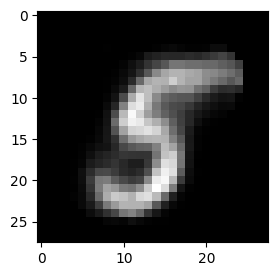

In [60]:
#Generating an image by passing a random sample from the latent space to decoder

z_test = tf.random.normal((1,32))
print(z_test)
l5 = dec_1(z_test)
l6 = dec_2(l5)
l7 = dec_3(l6)
l8 = dec_4(l7)

gen_img = tf.reshape(l8,(28,28))
plt.figure(figsize = (3,3))
plt.imshow(gen_img*255,cmap = 'gray')
plt.show()

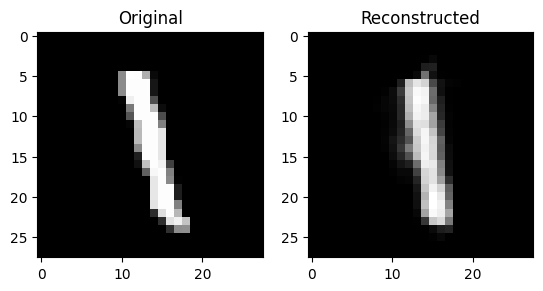

In [17]:
# A test sample and its VAE generated image

sample = X_test[700:701] #pick a sample(2D)
xhat, z, mu, logvar = forwardprop(sample)
plt.subplot(1, 2, 1)
plt.imshow(sample.reshape(28, 28), cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(xhat.numpy().reshape(28, 28), cmap='gray')
plt.title("Reconstructed")
plt.show()